Neural Network Model for water dimer potential energy
========
<img src="bpnn-dimer.png" alt="Drawing" style="width: 500px;"/>

## Table of contents
1. [Overview: the dataset and the goal](#intro)
2. [Load data: xyz coordinates, energies](#load-data)
3. [Exploratory analysis](#exploratory)
4. [Feature engineering](#feature-eng)
5. [Modeling: Nested Neural Network](#model)
6. [Model Evaluation](#model-eval)
7. [Applications](#application)


# Overview: The Dataset And The Goal <a name="intro"></a>

The goal is to build a machine learning model to predict accurately and efficiently energy for a water dimer system.

The dataset contains 42508 dimer structures. For each sample/structure, there are
- 18 Cartesian coordinates - input variables of continous type
- energy - target value of continous type


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
start =  time.time()
%matplotlib inline

np.random.seed(98167)  # for reproducibility

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float64,dnn.enabled=True"
#os.environ["KERAS_BACKEND"] = "tensorflow"
import keras 
from keras.layers import Input, Dense, Merge
from keras.models import Model, Sequential

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
#from keras.utils import np_utils

#===== setting for float64 for keras ======
from keras import backend as K
#K.set_floatx('float64')
#K.set_epsilon(1e-14)

Using Theano backend.
/server-home1/thuong/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:02:00.0)



# Load Data: xyz coordinates, energies  <a name="load-data"></a>

In [3]:
home = '/server-home1/thuong/Insight-demo'
data_orig =  pd.read_table(home + '/data/2b_to_fit_rounded.xyz', sep='\s+', names = range(4))

Natom = int(data_orig.iloc[0][0])
Nsamples = int(data_orig.shape[0]/(Natom+2))

# the first two samples
data_orig.head(16)

,0,1,2,3
0,6,NaN,NaN,NaN
1,2.61869,1.422530,1.704872e+01,-7.627810
2,O,0.066326,0.000000e+00,0.003700
3,H,-0.526324,-7.692395e-01,-0.029362
4,H,-0.526324,7.692395e-01,-0.029362
5,O,-0.066314,8.121121e-18,2.381301
6,H,0.480887,-5.889173e-17,3.184188
7,H,0.571564,-6.999636e-17,1.648383
8,6,NaN,NaN,NaN
9,-2.63248,-3.673540,8.955460e+00,-7.210620


In [4]:
print("Shape of the original data: ", data_orig.shape)
print("Number of samples in the dataset: ", Nsamples)

Shape of the original data:  (340064, 4)
Number of samples in the dataset:  42508


In [5]:
# atom-index mapping
at_idx_map = {'O': np.where(np.arange(Natom) %3 == 0)[0],\
              'H': np.where(np.arange(Natom) %3 != 0)[0]
             }
at_idx_map

{'H': array([1, 2, 4, 5]), 'O': array([0, 3])}

In [6]:
# target energies E_ref_orig
E_ref_orig = data_orig[data_orig.index % (Natom+2) == 1][2].astype(np.float).values
Eb_orig = data_orig[data_orig.index % (Natom+2) == 1][0].astype(np.float).values

In [7]:
# xyz coordinates
xyz = data_orig[data_orig.index % (Natom+2) >= 2][[1,2,3]].values
xyz[:3,:]

array([[ 0.06632633,  0.        ,  0.00370018],
       [-0.52632356, -0.76923955, -0.02936226],
       [-0.52632356,  0.76923955, -0.02936226]])


# Exploratory Analysis  <a name="exploratory"></a>

- Neglect ~ 400 samples with very high, irrelavant energies due to bad extrapolation


- Construct molecular distances from xyz coordinates.    
  Range and distribution of different intra/inter-molecular distances


- Split the dataset to traing-validation-test subsets

In [8]:
# train/val/test spliting 
train_idx = -1 + np.loadtxt(home + '/data/2Btrain_s15763498.idx').astype(np.int)
val_idx = -1 + np.loadtxt(home + '/data/2Bval_s15763498.idx').astype(np.int)
test_idx = -1 + np.loadtxt(home + '/data/2Btest_s15763498.idx').astype(np.int)
print('training:   number of samples ', len(train_idx), '; indexes', train_idx[:5])
print('validation: number of samples ', len(val_idx), ';  indexes', val_idx[:5])
print('test:       number of samples ', len(test_idx), ';  indexes', test_idx[:5])

training:   number of samples  34075 ; indexes [0 2 3 4 5]
validation: number of samples  3787 ;  indexes [10 13 18 20 21]
test:       number of samples  4207 ;  indexes [ 1  6  9 15 29]


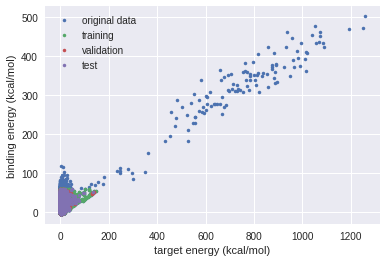

In [9]:
# plot target energies values
plt.plot(E_ref_orig, Eb_orig,'.', label='original data')
plt.plot(E_ref_orig[train_idx], Eb_orig[train_idx],'.', label='training')
plt.plot(E_ref_orig[val_idx], Eb_orig[val_idx],'.', label='validation')
plt.plot(E_ref_orig[test_idx], Eb_orig[test_idx],'.', label='test')
plt.xlabel('target energy (kcal/mol)')
plt.ylabel('binding energy (kcal/mol)')
plt.legend()
plt.show()

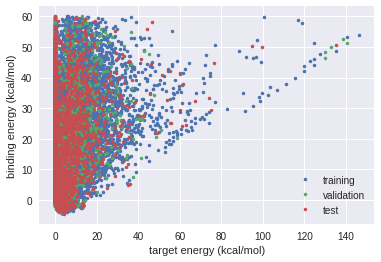

In [10]:
plt.plot(E_ref_orig[train_idx], Eb_orig[train_idx],'.', label='training')
plt.plot(E_ref_orig[val_idx], Eb_orig[val_idx],'.', label='validation')
plt.plot(E_ref_orig[test_idx], Eb_orig[test_idx],'.', label='test')
plt.xlabel('target energy (kcal/mol)')
plt.ylabel('binding energy (kcal/mol)')
plt.legend()
plt.show()

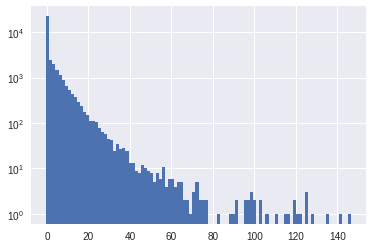

In [11]:
# plot target energy values in training set
plt.hist(E_ref_orig[train_idx], bins=100, log=True)
plt.show()

In [12]:
# Calculate distance dataframe from xyz coordinates
import src_nogrd
distances = src_nogrd.distances_from_xyz(xyz, Natom)
distances.head()

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(1, 2)","(1, 3)","(1, 4)","(1, 5)","(2, 3)","(2, 4)","(2, 5)","(3, 4)","(3, 5)","(4, 5)"
0,0.971626,0.971626,2.381298,3.207392,1.720537,1.538479,2.571893,3.454433,2.147537,2.571893,3.454433,2.147537,0.971626,0.971626,1.538479
1,0.971626,0.971626,2.645886,3.368464,1.831047,1.538479,2.818647,3.627053,2.194460,2.818647,3.627053,2.194460,0.971626,0.971626,1.538479
2,0.971626,0.971626,2.910475,3.564438,2.032414,1.538479,3.068374,3.819352,2.342211,3.068374,3.819352,2.342211,0.971626,0.971626,1.538479
3,0.971626,0.971626,3.175063,3.797181,2.275976,1.538479,3.320404,4.040540,2.548235,3.320404,4.040540,2.548235,0.971626,0.971626,1.538479
4,0.971626,0.971626,3.704241,2.797797,4.309907,1.538479,3.829550,3.021947,4.526349,3.829550,3.021947,4.526349,0.971626,0.971626,1.538479


In [13]:
#! sed -n 5,25p src_nogrd.py
help(src_nogrd.distances_from_xyz)

Help on function distances_from_xyz in module src_nogrd:

distances_from_xyz(xyz, Natom)
    calculate distances from coordinates
    # Arguments
        Natom: number (nb) of atoms; integer
        xyz: coordinates; 2D numpy array of shape (nb_samples * nb_atoms, 3)
        
    # Returns
        distances_df: distance values; pandas dataframe of shape (nb_samples, nb_distances),
                    column names as [(0,1),(0,2),...]



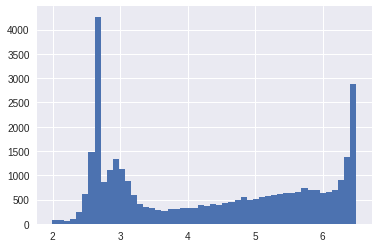

In [14]:
# O-O distance
distances.iloc[train_idx][(0,3)].hist(bins=50)
plt.show()

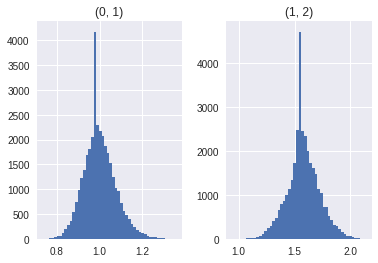

In [15]:
# O-H, H-H distances
distances.iloc[train_idx][[(1,2),(0,1)]].hist(bins=50)
plt.show()

In [16]:
print('max and min distances: ',' %.3f   %.3f' %(distances.values.max(), distances.values.min()))

max and min distances:   9.692   0.336



# Feature Engineering <a name="feature-eng"></a>

The radial and angular components of the symmetry functions (Gfuncs)
$$G_{i}^{\text{rad}} = \sum_{j \neq i} 
e^{-
\eta (R_{ij}-R_s)^2} 
$$

$$
G_{i}^{\text{ang}} = 2^{1-\zeta}\sum_{j \neq i} \sum_{k \neq i, j}  
 (1+\lambda \cos \theta_{ijk})^\zeta
e^{-\eta' (R_{ij}^2 + R_{ik}^2 + R_{jk}^2)} 
$$

A set of paramters, $(\eta, R_s)_{\text{rad}}$ and $(\zeta, \lambda, \eta')_{\text{ang}}$, characterized each set of features must be chosen to balance between the accuracy and the performance of the model.

### Parameters for a set of Gfunc feartures

In [17]:
# radial symmetry function parameters
Rs_array = np.linspace(0.8,8,num= 24)   # based on max and min of the distances
eta_array = 1./(2.0*np.square(0.2*Rs_array))
rad_params = np.array([(Rs_array[i],eta_array[i]) for i in range(len(Rs_array)) ])

# angular symmetry function parameters
lambd_array = np.array([-1, 1])
zeta_array = np.array([1, 4, 16])
eta_ang_array = np.array([0.001, 0.01, 0.05])
ang_comp = {'H': ['HO', 'HH'], 'O': ['HO', 'HH']}   
ang_params = np.array([[eta, zeta, lambd] for eta in eta_ang_array for zeta in zeta_array for lambd in lambd_array])

# Parameter dictionary
Gparam_dict = {}
for at1 in at_idx_map.keys():
    Gparam_dict[at1] = {}
    Gparam_dict[at1]['rad'] = {}
    for at2_rad in sorted(at_idx_map.keys()):
        if at1 == at2_rad and at1 == 'O':
            Gparam_dict[at1]['rad'][at2_rad] = rad_params[2:]
        else:
            Gparam_dict[at1]['rad'][at2_rad] = rad_params

    Gparam_dict[at1]['ang'] = {}
    for at23_ang in ang_comp[at1]:
        Gparam_dict[at1]['ang'][at23_ang] = ang_params


### Construct features - Gfuncs

In [18]:
Gfunc_data = src_nogrd.symmetry_function(distances, at_idx_map, Gparam_dict)

In [19]:
help(src_nogrd.symmetry_function)

Help on function symmetry_function in module src_nogrd:

symmetry_function(distances, at_idx_map, Gparam_dict)
    calculate symmetry functions from distances
    # Arguments
        distances: distance values; pandas dataframe of shape (nb_samples, nb_distances)
        at_idx_map: a mapping between atom types and atom indexes; dictionary
        Gparam_dict: symmetry function parameters; 
                        dictionary with 1st layer keys  = atom types,
                            2nd layer keys = symmetry function types (radial or angular)
                            values = 2D arrays of sym. function parameters of 
                            shape (nb_sym_functions, nb_filter_parameters)
                        
    # Returns        
       Gfunc_data: symmetry function values; 
                    dictionary with 1st layer keys = atom types,
                        2nd layer keys = atom indexes,
                        values = 2D arrays with shape=(nb_samples, nb_sym_functi

In [20]:
Gfunc_data['H'][1].shape

(42508, 84)


# Modeling: Nested Neural Network  <a name="model"></a>

<img src="bpnn.png" alt="Drawing" style="width: 500px;"/>

### Create a network with shared-substructures

To preserve permutation invariance of the energies, all atoms of the same chemical species need to share the same atomic sub-network. Therefore, for water systems considered here, there are two sub-networks simultaneously trained, one for all Gfuncs with oxygen and the other with all Gfuncs corresponding to hydrogen. 


In [21]:
nUnit = 34 #int(os.environ['unit_number'])
def Nguyen_Widrow_init(shape, dtype=None):
    '''Nguyen-Widrow initialization for weights and biases'''
    n_input, n_unit = shape[0], shape[1]  # n_input: number of units of prev. layer without bias 
    w_init = np.random.rand(n_input, n_unit) *2 -1
    norm = 0.7 * n_unit ** (1. / n_input)
    # normalize 
    w = norm * w_init/np.sqrt(np.square(w_init).sum(axis=0).reshape(1, n_unit))
    if n_unit>1:
        b = norm * np.linspace(-1,1,n_unit) * np.sign(w[0,:]) 
    else: 
        b = np.zeros((n_unit,)) 
    return [w, b]

def create_base_network(input_dim):
    '''3-layer base network to be shared among atoms of the same species 
    '''    
    seq = Sequential()
    seq.add(Dense(nUnit, input_shape=(input_dim,), activation='tanh'))
    shape0 = (seq.layers[0].input_shape[1], seq.layers[0].output_shape[1]) 
    seq.layers[0].set_weights(Nguyen_Widrow_init(shape0))
    
    seq.add(Dense(nUnit, activation='tanh'))
    shape1 = (seq.layers[1].input_shape[1], seq.layers[1].output_shape[1]) 
    seq.layers[1].set_weights(Nguyen_Widrow_init(shape1))
    
    seq.add(Dense(nUnit, activation='tanh'))
    shape2 = (seq.layers[2].input_shape[1], seq.layers[2].output_shape[1]) 
    seq.layers[2].set_weights(Nguyen_Widrow_init(shape2))

    seq.add(Dense(1, activation='linear'))
    shape3 = (seq.layers[3].input_shape[1], seq.layers[3].output_shape[1]) 
    seq.layers[3].set_weights(Nguyen_Widrow_init(shape3)) 
    return seq

def main_network(input_dim_list):
    '''Main neural network with shared sub-structures'''
    type_nb = len(input_dim_list)
    base_network = {}
    inp = {}
    processed = {}
    
    # atomic inputs of the same species are processed through the same sub-network. 
    for at_type in range(type_nb):
        dims = input_dim_list[at_type]
        
        # sub-network definition
        base_network[at_type] = create_base_network(dims[1])
        
        processed[at_type] = {}
        inp[at_type] = {} 
        for atA in range(dims[0]):
            # input preparation
            inp[at_type][atA] = Input(shape=(dims[1],),dtype='float64')
            
            # because we re-use the same instance `base_network`,
            # the weights of the sub-network will be shared across same-type atomic branches 
            processed[at_type][atA] = base_network[at_type](inp[at_type][atA])
    
    # total energy as a sum of all atomic energies
    subnn_outputs = [processed[u][v] for u in processed.keys() for v in processed[u].keys()]
    main_output = keras.layers.add(subnn_outputs)
    
    # main network definition
    inputs = [inp[u][v] for u in inp.keys() for v in inp[u].keys()]
    main_network = Model(inputs, main_output)    
    return main_network

In [22]:
input_dim_list = [(len(at_idx_map[t]),Gfunc_data[t][at_idx_map[t][0]].shape[1]) for t in at_idx_map.keys()]
input_dim_list

[(2, 82), (4, 84)]

In [23]:
model = main_network(input_dim_list)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 82)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 82)            0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 84)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 84)            0                                            
___________________________________________________________________________________________


### Fearure Processing For NN Inputs

In [24]:
# rescale target values 
Eunit = 0.0433634/6    ## Energy to fit per atom in eV unit; 1 kcal/mol = 0.0433634 eV
y_train = E_ref_orig[train_idx] * Eunit 
y_val   = E_ref_orig[val_idx] * Eunit
y_test  = E_ref_orig[test_idx] * Eunit

In [25]:
print('y_train min, max = ', '%.3f  %.3f' %(y_train.min(), y_train.max() ))
print('y_test min, max = ', '%.3f  %.3f' %(y_test.min(), y_test.max()) )

y_train min, max =  -0.002  1.058
y_test min, max =  -0.002  0.977


In [26]:
# rescale each feature with its atom-type maximum value
train_scaled = {}
val_scaled = {}
test_scaled = {}

for at_type in at_idx_map.keys():
    train_scaled[at_type] = {}
    val_scaled[at_type] = {}
    test_scaled[at_type] = {}
    
    count=0
    # find maximum values in the set of features for each atom type
    for at in at_idx_map[at_type]:
        temp = Gfunc_data[at_type][at] 
        if count==0:
            tmp_max = np.maximum(np.max(temp[train_idx], axis=0),np.max(temp[val_idx], axis=0))
        else:
            tmp_max = np.maximum(tmp_max, np.maximum(np.max(temp[train_idx], axis=0),np.max(temp[val_idx], axis=0)))
        count += 1
    
    # rescale each feature to atom-type corresoinding maximum value
    for at in at_idx_map[at_type]:
        temp = Gfunc_data[at_type][at] 
        print(at, temp.shape)  
        train, val, test = temp[train_idx], temp[val_idx], temp[test_idx]
        train_scaled[at_type][at] = train/tmp_max
        val_scaled[at_type][at] = val/tmp_max 
        test_scaled[at_type][at] = test/tmp_max 


0 (42508, 82)
3 (42508, 82)
1 (42508, 84)
2 (42508, 84)
4 (42508, 84)
5 (42508, 84)


In [27]:
# inputs for NN
inp_train = [train_scaled[u][v] for u in at_idx_map.keys() for v in at_idx_map[u]] 
inp_val = [val_scaled[u][v] for u in at_idx_map.keys() for v in at_idx_map[u]]
inp_test = [test_scaled[u][v] for u in at_idx_map.keys() for v in at_idx_map[u]]

### Neural Network Training

In [28]:
model_folder = "model_2B_nUnit"
!mkdir $model_folder

check1 = model_folder +'/' + str(nUnit) + '.hdf5'
checkpointer = ModelCheckpoint(filepath=check1, verbose=0,  monitor='val_mean_squared_error',\
                               mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_mean_squared_error', mode='min', patience=100, verbose=0)

mkdir: cannot create directory ‘T-model_2B_nUnit’: File exists


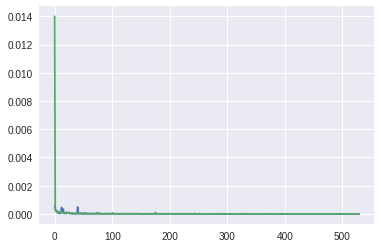

In [29]:
# 1st learning rate training
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history = model.fit(inp_train, y_train, \
                    callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1200, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.show()

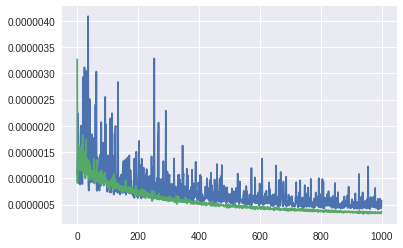

In [30]:
# 2nd learning rate training
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0002,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history2 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1000, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )
plt.plot(history2.history['val_mean_squared_error'])
plt.plot(history2.history['mean_squared_error'])
plt.show()

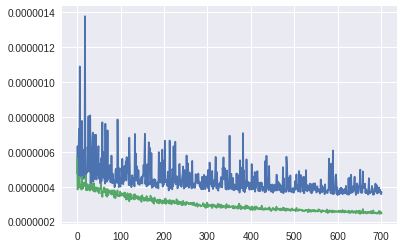

In [31]:
# 3rd learning rate training
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.00006,decay=1e-5), 
              metrics=['mean_squared_error', 'mean_absolute_error'])

history3 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1000, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )
plt.plot(history3.history['val_mean_squared_error'])
plt.plot(history3.history['mean_squared_error'])
plt.show()

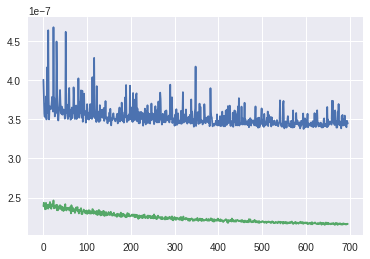

In [32]:
# 4th learning rate training
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.000009,decay=1e-5),
              metrics=['mean_squared_error', 'mean_absolute_error'])

history4 = model.fit(inp_train, y_train, \
                     callbacks=[checkpointer, earlystop],
                    batch_size=64, epochs=1000, shuffle=True,
                    verbose=0, validation_data=(inp_val, y_val)
                    )
plt.plot(history4.history['val_mean_squared_error'])
plt.plot(history4.history['mean_squared_error'])
plt.show()

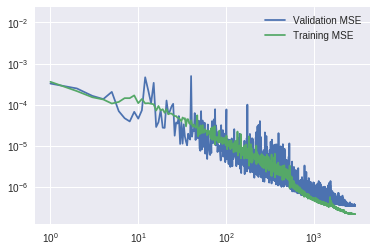

In [33]:
# error through training process
plt.loglog(history.history['val_mean_squared_error'] + history2.history['val_mean_squared_error'] \
           + history3.history['val_mean_squared_error']+ history4.history['val_mean_squared_error'] \
           , label='Validation MSE')
plt.loglog(history.history['mean_squared_error'] + history2.history['mean_squared_error']\
           + history3.history['mean_squared_error']+ history4.history['mean_squared_error'] \
           , label='Training MSE')
plt.legend()
plt.show()


# Model Evaluation  <a name="model-eval"></a>

In [34]:
# Load model weights
model.load_weights(check1)

In [35]:
# Error on TEST set 
y_pred_scaled = model.predict(inp_test)
y_pred = y_pred_scaled.T[0]/Eunit   # in kcal/mol unit
y_obs = y_test/Eunit 

err_test = np.sqrt(mean_squared_error(y_pred, y_obs))
errAbs_test = mean_absolute_error(y_pred, y_obs) 
print('RMSE_test:', '%.4f' % err_test)
print('MAE_test:','%.4f' % errAbs_test)
print('The mean value of energies in test set: ', '%.4f' %E_ref_orig[test_idx].mean())

RMSE_test: 0.0999
MAE_test: 0.0394
The mean value of energies in test set:  3.0087


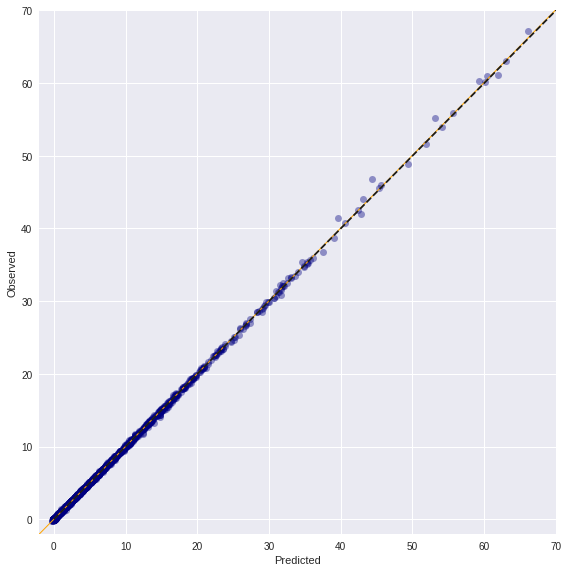

In [36]:
# Scatter plot of predicted and true values of energies in the test set
x1 = pd.Series(y_pred, name="Predicted")
x2 = pd.Series(y_obs, name="Observed")

data1 = pd.concat([x1, x2], axis=1)
g = sns.lmplot("Predicted", "Observed", data1,
           scatter_kws={"marker": ".", "color": "navy", "alpha": 0.4 },
           line_kws={"linewidth": 1, "color": "orange"},
              size=8, aspect=1);
plt.plot([0, 120], [0, 120], ls="--", c=".1")
g.set(xlim=(-2, 70), ylim=(-2, 70));

In [37]:
# Error on TRAINING set
y_train_pred_scaled = model.predict(inp_train)
y_train_pred = y_train_pred_scaled.T[0]/Eunit   # in kcal/mol unit
y_train_obs = y_train/Eunit 

err_train = np.sqrt(mean_squared_error(y_train_pred, y_train_obs))
errAbs_train = mean_absolute_error(y_train_pred, y_train_obs)
print('RMSE_train:','%.4f' % err_train)
print('MAE_train:','%.4f' % errAbs_train)

RMSE_train: 0.0639
MAE_train: 0.0327


In [38]:
# Error on VALIDATION set 
y_val_pred_scaled = model.predict(inp_val)
y_val_pred = y_val_pred_scaled.T[0]/Eunit   # in kcal/mol unit
y_val_obs = y_val/Eunit 

err_val = np.sqrt(mean_squared_error(y_val_pred, y_val_obs))
errAbs_val = mean_absolute_error(y_val_pred, y_val_obs)
print('RMSE_val:','%.4f' % err_val)
print('MAE_val:','%.4f' % errAbs_val)


RMSE_val: 0.0804
MAE_val: 0.0363


In [39]:
end =  time.time()
print('Running time is %f mins' %((end - start)/60))

Running time is 51.251598 mins



# Applications <a name="application"></a>

- Results on represeting water dimer, trimer CCSD(T) datasets and water cluster total energies ([reported here](https://aip.scitation.org/doi/10.1063/1.5024577))

<img src="pip-nn.png" alt="Drawing" style="width: 500px;"/>

- Work in progress: various reference datasets at different levels of accuracy and computational cost. 

<img src="mb-dft/RMSEs.png" alt="Drawing" style="width: 500px;"/>

Preliminary results for the radial distribution functions for liquid water using regression model with high order polynomials compared to experimental data.

<img src="mb-dft/RDF_C6-polar-dft.png" alt="Drawing" style="width: 500px;"/>